# CNN Classifiers

In [1]:
import numpy as np
import pandas as pd
from sklearn import metrics
from sklearn import model_selection
import pkg_resources
import time
import os
from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Embedding
from keras.models import Model
from keras.layers import Input
from keras.layers import Conv1D
from keras.layers import MaxPooling1D
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import Dense
from keras.optimizers import RMSprop
from keras.models import load_model
import matplotlib.pyplot as plt

In [2]:
train = pd.read_csv('D:/NEU/Fall 2020/NLP/Project/train.csv')
train = train[:50]

In [5]:
# Extract all comments as strings
train['comment_text'] = train['comment_text'].astype(str)

# identities that we're going to do analysis on:
# all these identities had more than 500 mentions in test set
identities = ['male', 'female', 'homosexual_gay_or_lesbian', 'christian', 'jewish',
    'muslim', 'black', 'white', 'psychiatric_or_mental_illness']

In [6]:
# binarize target column and add identity boolean columns
def convert_to_bool(df):
    bool_df = df.copy()
    for col in ['target'] + identities:
        bool_df[col] = np.where(df[col] >= 0.5, True, False)
    return bool_df

train = convert_to_bool(train)

In [7]:
# splitting data into 80% training set and 20% validation set
train_df, validate_df = model_selection.train_test_split(train, test_size=0.2)

In [8]:
MAX_NUM_WORDS = 10000
MAX_SEQUENCE_LENGTH = 200
tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer.fit_on_texts(train_df['comment_text'])

#Padding comments to make the vectors of the same length
def pad_text(texts, tokenizer):

    return pad_sequences(tokenizer.texts_to_sequences(texts), maxlen=MAX_SEQUENCE_LENGTH)

In [9]:
# train the glove 50 cnn model
# pre trained word vectors (glove 50) were used

EMBEDDINGS_DIM = 50 #Embedding dimension will take values 50, 100, and 200.
PATH = 'D:/NEU/Fall 2020/NLP/Project/glove.6B.50d.txt'
EPOCHS = 7
L_R = 0.00006
DROPOUT = 0.25
BATCH_SIZE = 128
history = None

In [36]:
# helper function to train and preprocess training and validation sets

def train_model(train_df, validate_df, tokenizer):

    #Preprocessing the training and validation data frames

    text_train = pad_text(train_df['comment_text'], tokenizer)
    labels_train = to_categorical(train_df['target'])

    text_val = pad_text(validate_df['comment_text'], tokenizer)
    labels_val = to_categorical(validate_df['target'])

    print('loading embeddings')
    embeddings_idx = {}
    with open(PATH, encoding='utf-8') as f:
        for line in f:
            vals = line.split()
            word = vals[0]
            coefs = np.asarray(vals[1:], dtype='float32')
            embeddings_idx[word] = coefs

    embedding_matrix = np.zeros((len(tokenizer.word_index) + 1, EMBEDDINGS_DIM))
    embedding_words = 0
    for word, i in tokenizer.word_index.items():
        embedding_vector = embeddings_idx.get(word)
        if embedding_vector is not None:
            embedding_words += 1
            embedding_matrix[i] = embedding_vector

    #Creating CNN Layers
    def get_cnn_layers():
        input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
        embedding_layer = Embedding(len(tokenizer.word_index) + 1, EMBEDDINGS_DIM, weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH, trainable=False)
        z = embedding_layer(input)
        z = Conv1D(128, 2, activation='relu', padding='same')(z)
        z = MaxPooling1D(5, padding='same')(z)
        z = Conv1D(128, 3, activation='relu', padding='same')(z)
        z = MaxPooling1D(5, padding='same')(z)
        z = Conv1D(128, 4, activation='relu', padding='same')(z)
        z = MaxPooling1D(40, padding='same')(z)
        z = Flatten()(z)
        z = Dropout(DROPOUT)(z)
        z = Dense(128, activation='relu')(z)
        output = Dense(2, activation='softmax')(z)
        return input, output
    # maxpooling and colvolution layers were used in the cnn. rele activation functions were used in the convolution layers


    input_layer, output_layer = get_cnn_layers()
    model = Model(input_layer, output_layer)
    model.compile(loss='categorical_crossentropy', optimizer=RMSprop(lr=L_R), metrics=['acc'])

    #Training
    print('training model')
    global history
    history = model.fit(text_train, labels_train, batch_size=BATCH_SIZE, epochs=EPOCHS,
            validation_data=(text_val, labels_val), verbose=2)

    return model


loading embeddings
training model
Epoch 1/7
1/1 - 0s - loss: 0.9000 - acc: 0.1250 - val_loss: 0.6998 - val_acc: 0.4000
Epoch 2/7
1/1 - 0s - loss: 0.7640 - acc: 0.2750 - val_loss: 0.6777 - val_acc: 0.6000
Epoch 3/7
1/1 - 0s - loss: 0.7040 - acc: 0.4500 - val_loss: 0.6652 - val_acc: 0.7000
Epoch 4/7
1/1 - 0s - loss: 0.6591 - acc: 0.6500 - val_loss: 0.6563 - val_acc: 0.7000
Epoch 5/7
1/1 - 0s - loss: 0.5997 - acc: 0.7500 - val_loss: 0.6516 - val_acc: 0.7000
Epoch 6/7
1/1 - 0s - loss: 0.5734 - acc: 0.9000 - val_loss: 0.6489 - val_acc: 0.7000
Epoch 7/7
1/1 - 0s - loss: 0.5419 - acc: 0.8750 - val_loss: 0.6471 - val_acc: 0.7000


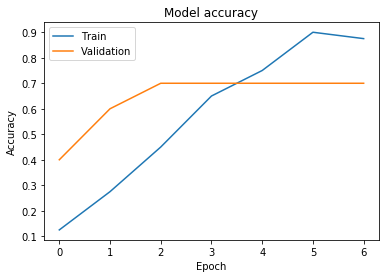

In [37]:
# training the model
model = train_model(train_df, validate_df, tokenizer)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

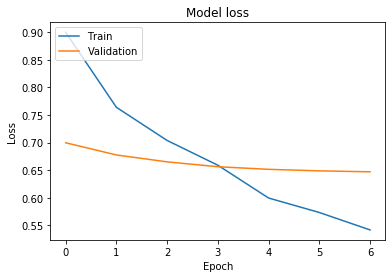

In [38]:
# training and validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [53]:
# predictions on validation set
MODEL_NAME = 'my_model'
validate_df[MODEL_NAME] = model.predict(pad_text(validate_df['comment_text'], tokenizer))[:, 1]
validate_df

C:\Users\karth\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,id,target,comment_text,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,...,rating,funny,wow,sad,likes,disagree,sexual_explicit,identity_annotator_count,toxicity_annotator_count,my_model
27,239603,False,Our aim is actually the opposite: we want spir...,0.000000,0.000000,0.0,0.000000,0.0,NaN,NaN,...,approved,0,0,0,2,0,0.000000,0,4,0.274170
19,239592,True,"Angry trolls, misogynists and Racists"", oh my....",0.000000,0.000000,0.1,0.500000,0.0,0.0,0.0,...,approved,0,0,0,0,0,0.000000,4,10,0.325613
41,239627,False,Very cool project!,0.000000,0.000000,0.0,0.000000,0.0,NaN,NaN,...,approved,0,0,0,3,0,0.000000,0,4,0.446669
5,59859,True,ur a sh*tty comment.,0.047619,0.638095,0.0,0.333333,0.0,NaN,NaN,...,rejected,0,0,0,0,0,0.009524,0,105,0.455351
3,59855,False,Is this something I'll be able to install on m...,0.000000,0.000000,0.0,0.000000,0.0,NaN,NaN,...,rejected,0,0,0,0,0,0.000000,0,4,0.377582
8,239575,False,The ranchers seem motivated by mostly by greed...,0.000000,0.000000,0.0,0.000000,0.0,NaN,NaN,...,approved,0,0,0,0,0,0.000000,0,4,0.388236
20,239593,False,Nice to some attempts to try to make comments ...,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,...,approved,0,0,0,4,0,0.000000,4,4,0.396421
14,239584,True,This story gets more ridiculous by the hour! A...,0.000000,0.000000,0.0,0.300000,0.0,NaN,NaN,...,approved,0,0,0,9,0,0.000000,0,10,0.342766
1,59849,False,Thank you!! This would make my life a lot less...,0.000000,0.000000,0.0,0.000000,0.0,NaN,NaN,...,rejected,0,0,0,0,0,0.000000,0,4,0.393451
33,239611,False,Troll free since 2016.,0.000000,0.000000,0.0,0.000000,0.0,NaN,NaN,...,approved,0,0,0,2,0,0.000000,0,4,0.456251


In [61]:
validate_df.head()

,id,target,comment_text,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,...,rating,funny,wow,sad,likes,disagree,sexual_explicit,identity_annotator_count,toxicity_annotator_count,my_model
27,239603,False,Our aim is actually the opposite: we want spir...,0.000000,0.000000,0.0,0.000000,0.0,NaN,NaN,...,approved,0,0,0,2,0,0.000000,0,4,0.274170
19,239592,True,"Angry trolls, misogynists and Racists"", oh my....",0.000000,0.000000,0.1,0.500000,0.0,0.0,0.0,...,approved,0,0,0,0,0,0.000000,4,10,0.325613
41,239627,False,Very cool project!,0.000000,0.000000,0.0,0.000000,0.0,NaN,NaN,...,approved,0,0,0,3,0,0.000000,0,4,0.446669
5,59859,True,ur a sh*tty comment.,0.047619,0.638095,0.0,0.333333,0.0,NaN,NaN,...,rejected,0,0,0,0,0,0.009524,0,105,0.455351
3,59855,False,Is this something I'll be able to install on m...,0.000000,0.000000,0.0,0.000000,0.0,NaN,NaN,...,rejected,0,0,0,0,0,0.000000,0,4,0.377582


In [54]:
SUBGROUP_AUC = 'subgroup_auc'
BPSN_AUC = 'bpsn_auc'  # stands for background positive, subgroup negative
BNSP_AUC = 'bnsp_auc'  # stands for background negative, subgroup positive

In [55]:
def get_auc(y_true, y_pred):
    try:
        return metrics.roc_auc_score(y_true, y_pred)
    except ValueError:
        return np.nan

def get_subgrp_auc(df, subgroup, label, model_name):
    subgroup_examples = df[df[subgroup]]
    return get_auc(subgroup_examples[label], subgroup_examples[model_name])


def calculate_bpsn(df, subgroup, label, model_name):
    #bpsn stands for background positive, subgroup negative, i.e we compute the score
    #of the within subgroup of negative examples and the background positive ones.

    subgroup_neg = df[df[subgroup] & ~df[label]]
    non_subgroup_pos = df[~df[subgroup] & df[label]]
    examples = subgroup_neg.append(non_subgroup_pos)
    return get_auc(examples[label], examples[model_name])

def calculate_bnsp(df, subgroup, label, model_name):
    #bsnp stands for background negative, subgroup positive. Similarly, we compute the score of
    #the within subgroup of positive examples and the background negative ones.

    subgroup_pos = df[df[subgroup] & df[label]]
    non_subgroup_neg = df[~df[subgroup] & ~df[label]]
    examples = subgroup_pos.append(non_subgroup_neg)
    return get_auc(examples[label], examples[model_name])


def compute_bias_metrics(dataset, subgroups, model, label_column, include_asegs=False):
    records = []
    for subgroup in subgroups:
        record = {
            'subgroup': subgroup,
            'subgroup_size': len(dataset[dataset[subgroup]])
        }
        record['subgroup_auc'] = get_subgrp_auc(dataset, subgroup, label_column, model)
        record['bpsn_auc'] = calculate_bpsn(dataset, subgroup, label_column, model)
        record['bnsp_auc'] = calculate_bnsp(dataset, subgroup, label_column, model)
        records.append(record)
    return pd.DataFrame(records).sort_values('subgroup_auc', ascending=True)


In [56]:
bias_metrics_df = compute_bias_metrics(validate_df, identities, MODEL_NAME, 'target')
print(bias_metrics_df)

                        subgroup  subgroup_size  subgroup_auc  bpsn_auc  \
0                           male              0           NaN       NaN   
1                         female              0           NaN       NaN   
2      homosexual_gay_or_lesbian              0           NaN       NaN   
3                      christian              0           NaN       NaN   
4                         jewish              0           NaN       NaN   
5                         muslim              0           NaN       NaN   
6                          black              0           NaN       NaN   
7                          white              0           NaN       NaN   
8  psychiatric_or_mental_illness              0           NaN       NaN   

   bnsp_auc  
0       NaN  
1       NaN  
2       NaN  
3       NaN  
4       NaN  
5       NaN  
6       NaN  
7       NaN  
8       NaN  


In [57]:
def power_mean(series, p):
    total = sum(np.power(series, p))
    return np.power(total / len(series), 1 / p)


def overall_auc(df, model_name):
    true_labels = df['target']
    predicted_labels = df[model_name]
    return metrics.roc_auc_score(true_labels, predicted_labels)


def get_final_metric(bias_df, overall_auc, POWER=-5, OVERALL_WEIGHT=0.25):
    bias_score = np.average([power_mean(bias_df['subgroup_auc'], POWER), power_mean(bias_df['bpsn_auc'], POWER),
                            power_mean(bias_df['bnsp_auc'], POWER)])
    return (OVERALL_WEIGHT * overall_auc) + ((1 - OVERALL_WEIGHT) * bias_score)

In [58]:
get_final_metric(bias_metrics_df, overall_auc(validate_df, MODEL_NAME))


nan